In [6]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
dataset_path = "/home/tanuj/Brain_MRI/brain_tumor_mri_dataset"

print('Data source import complete.')



Data source import complete.


# Introduction to Problem of Brain Tumor

A brain tumor is one of the most dangerous diseases that can affect both children and adults. The majority of primary Central Nervous System (CNS) tumors are brain tumors, which account for 85 to 90% of all cases. Around 11,700 people are diagnosed with a brain tumor each year. People with a cancerous brain or CNS tumor have a 5-year survival rate of approximately 34% for men and 36% for women. Glioma Tumors, Meningioma Tumors, Pituitary Tumors, and other types of brain tumors are classified. To increase the patients' life expectancy, proper treatment, planning, and accurate diagnostics should be implemented. Magnetic Resonance Imaging (MRI) is the most effective method for detecting brain tumors. The scans generate a tremendous amount of image data. The radiologist inspects these photographs. Because of the complexity involved in brain tumors and their properties, a manual examination can be prone to errors.

# Objective

Deep learning is being used to forecast a variety of brain tumor. The major objectives of this notebook are to attain a high level of brain tumor prediction accuracy. Deep learning approaches assist in the early diagnosis of brain tumor. The classification of brain tumor relies heavily on feature extraction. Human labor, such as manual feature extraction and data reconstruction for classification purposes, is reduced when Deep Learning algorithms are used. As a result, proposing a system that uses Deep Learning Algorithms using Convolution Neural Network (CNN) and Transfer Learning (TL) to do classification will be beneficial to doctors all over the world.

# Description of the Brain tumor Dataset

The dataset is organized into 2 folders (Training, Testing) and contains 4 subfolders for each image category. There are 3,264 MRI images (JPEG) and 4 categories (Glioma/Meningioma/Pituitary/No_tumor).
1. Training set
* Glioma tumor (826 images)
* Meningioma tumor (822 images)
* No tumor (395 images)
* Pituitary tumor (827 images)
2. Testing set
* Glioma tumor (100 images)
* Meningioma tumor (115 images)
* No tumor (105 images)
* Pituitary tumor (74 images)

# Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

2025-04-13 11:06:48.004631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744522608.058575  196206 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744522608.074775  196206 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744522608.114561  196206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744522608.114615  196206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744522608.114622  196206 computation_placer.cc:177] computation placer alr

# Data Preperation

Appending all the images from the directories into a list and then converting them into numpy arrays after resizing it.

In [4]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/home/tanuj/Brain_MRI/brain_tumor_mri_dataset/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/home/tanuj/Brain_MRI/brain_tumor_mri_dataset/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 374/374 [00:00<00:00, 597.65it/s]


**Previewing the images in each classes**

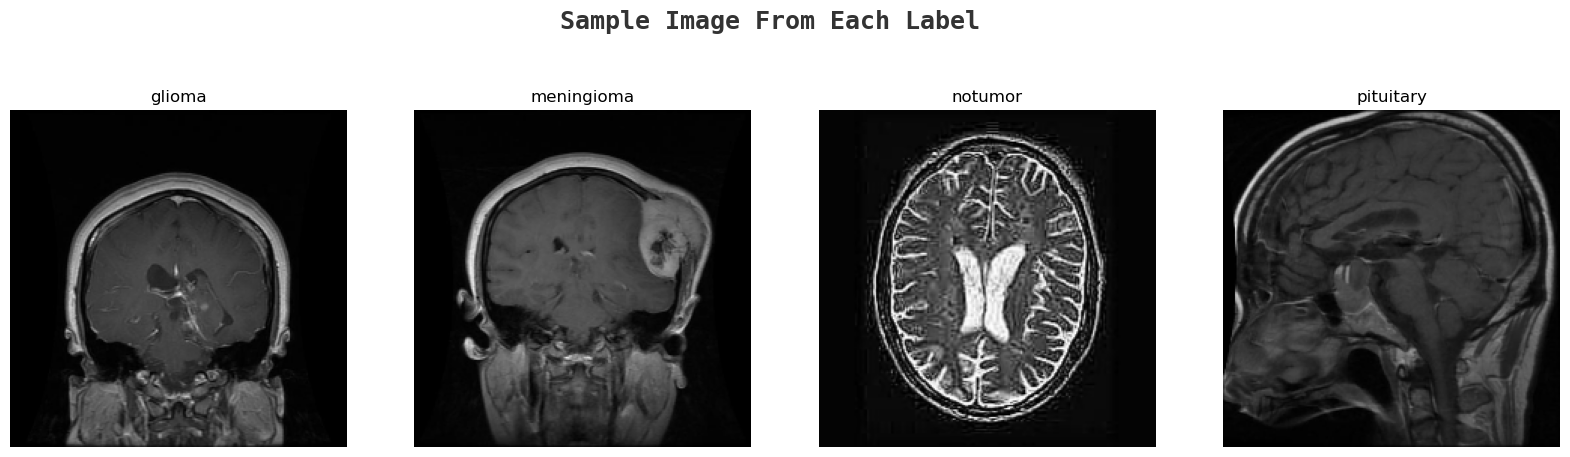

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

**Shuffle the train set**

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

**Print out train set shape**

In [8]:
X_train.shape

(8582, 224, 224, 3)

**Print out test set shape**

In [9]:
X_test.shape

(1705, 224, 224, 3)

**Show the counts of observations in each categorical**

<Axes: xlabel='count'>

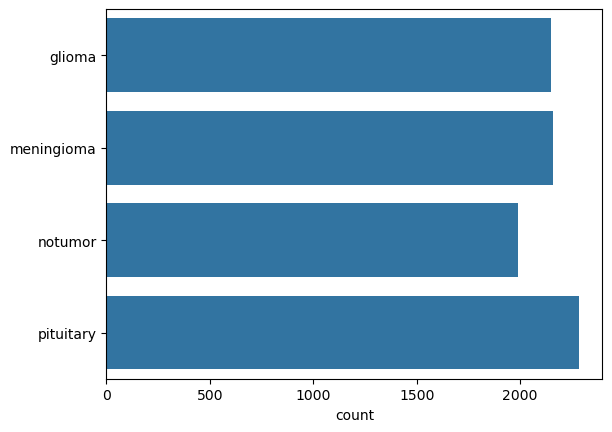

In [10]:
sns.countplot(y_train)

<Axes: xlabel='count'>

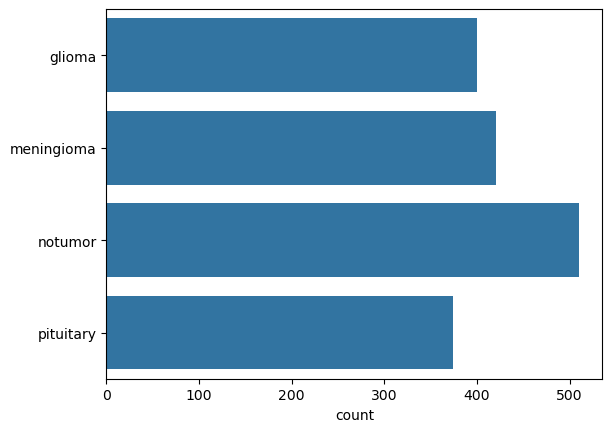

In [11]:
sns.countplot(y_test)

**Performing One Hot Encoding on the labels after converting it into numerical values**

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**Dividing the dataset into Training and Testing sets.**

In [13]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

**Normalize the data**

In [ ]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

**Data Augmentation**


To prevent the problem of overfitting, we can artificially enlarge the dataset. I can increase the size of the current dataset. The idea is to alter the training data with small transformations to reproduce the variations.   Data augmentation strategies are methods for changing the array representation while keeping the label the same while altering the training data. Grayscales, horizontal and vertical flips, random crops, color jitters, translations, rotations, and many other augmentations are popular. I can easily double or increase the number of training examples by applying only a couple of these changes to the training data.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

For the data augmentation, i choosed to :
1.   Randomly rotate some training images by 10 degrees.
2.   Randomly Zoom by 10% some training images.
3.   Randomly shift images horizontally by 10% of the width.
4.   Randomly shift images vertically by 10% of the height.
5.   Randomly flip images horizontally.

**Callback function**


Callbacks can help fix bugs more quickly, and can help build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using TensorBoard, ModelCheckpoint and ReduceLROnPlateau callback functions

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# Detail of model implementation

**CNN approach**

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(512))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4))
model_cnn.add(Activation('softmax'))

model_cnn.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_cnn.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

In [ ]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

I've used the argmax function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

**Evaluation**

In [ ]:
model_cnn.evaluate(X_train, y_train)

In this,

*   0 - Glioma Tumor
*   1 - Meningioma Tumor
*   2 - No Tumor
*   3 - Pituitary Tumo

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Transfer learning approach**

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. In this project I use pretrained models like VGG-16 and EfficientNetB0. Which is trained on large ImageNet dataset.

The ImageNet project is a large visual database designed for use in visual object recognition software research. More than 14 million images have been hand-annotated by the project to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided. ImageNet contains more than 20,000 categories with a typical category, such as "balloon" or "strawberry", consisting of several hundred images.

**VGG16**

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [ ]:
vgg=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False)

In [ ]:
for layers in vgg.layers:
  layers.trainable=False

In [ ]:
model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.15)(model_vgg)
model_vgg = Dense(4,activation='softmax')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_vgg.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

In [ ]:
model_vgg.save('vgg16_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [ ]:
pred = model_vgg.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

**Evaluation**

In [ ]:
model_vgg.evaluate(X_train, y_train)

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**EfficientNetB0**

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model_eff = effnet.output
model_eff = tf.keras.layers.GlobalAveragePooling2D()(model_eff)
model_eff = tf.keras.layers.Dropout(rate=0.5)(model_eff)
model_eff = tf.keras.layers.Dense(4,activation='softmax')(model_eff)
model_eff = tf.keras.models.Model(inputs=effnet.input, outputs = model_eff)
model_eff.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_eff, to_file='model_eff_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_eff.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
history = model_eff.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

In [ ]:
model_eff.save('model_eff.h5')

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [ ]:
pred = model_eff.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

**Evaluation**

In [ ]:
model_eff.evaluate(X_train, y_train)

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

# Grad-CAM visualization

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

**Grad-CAM of VGG16**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../input/brain-tumor-classification-mri/Training/meningioma_tumor/m3 (14).jpg"

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

**Grad-CAM of EfficientNetB0**

In [ ]:
model_builder = tf.keras.applications.efficientnet.EfficientNetB0
img_size = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"

In [ ]:
img_path ="../input/brain-tumor-classification-mri/Training/meningioma_tumor/m3 (14).jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

# Experimental results

In [ ]:
# Function to convert output labels to its class of tumor.
def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'

**Prediction using CNN model**

In [ ]:
train_pred = model_cnn.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

In [ ]:
test_pred = model_cnn.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

In [ ]:
# Prediction using CNN model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

**Prediction using VGG16 model**

In [ ]:
train_pred = model_vgg.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

In [ ]:
test_pred = model_vgg.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

In [ ]:
# Prediction using VGG16 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_vgg.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

**Prediction using EfficientNetB0**

In [ ]:
train_pred = model_eff.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

In [ ]:
test_pred = model_eff.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

In [ ]:
# Prediction using EfficientNetB0 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_eff.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

# Conclusion

In this notebook, I performed Image Classification (Brain tumor MRI images) with the help of CNN and Transfer Learning on VGG16 and EfficientNetB0.

>For CNN, the accuracy on training set is 99.38%, but the accuracy on testing set is 71.07%.

>For VGG16, the accuracy on training set is 97.41%, but the accuracy on testing set: 75.89%.

>For EfficientNetB0, the accuracy on training set is 99.85%, but the accuracy on testing set: 78.93%.

As you can see from the results, the Transfer Learning method gave a better performance of the model over the traditional CNN method. Instead of training a model from scratch, I can use existing architectures that have been trained on a large dataset and then tune them for my task. This reduces the time to train and often results in better overall performance in the Transfer learning process.